# Alpha and Beta for Small Stocks
<b>BACKGROUND</b><br>
<b>Alpha</b> and <b>Beta</b> are important concepts in portfolio management that can be estimated by linear regression. For a given focal stock relative to a reference basket of stocks,
* <b>alpha</b> = the percent return of the focal stock independent of the return of the reference basket
* <b>beta</b> = the incremental return of the focal stock per unit return of the reference basket

The reference basket of stocks serves as a market benchmark.  The reference basket could be an index like the S&P 500 or an exchange-traded fund (ETF) that mimics an index or holds some other group of stocks. 

Alpha and beta are estimated by regression of daily percent returns of the focal stock on daily percent returns of the reference basket, where beta is the slope parameter and alpha is the intercept parameter.  For example, beta = 1.20 means that the focal stock will, on average, increase (decrease) 1.2% per 1% increase (decrease) in the reference basket.  Alpha = +0.0005 means that the focal stock will, on average, increase 0.05% per day when the reference basket has a 0% daily return.

Beta tells us how much return to expect in the focal stock due to its correlation with a market benchmark. Alpha tells us how much return to expect in the focal stock independent of a market benchmark. A stock with alpha = 0.0% and beta = 1.0 will have the same return as the market benchmark.

Alpha and beta are interesting because they tell us how much of a stock's return is attributable to the overall market and how much of a stock's return is attributable to factors that are specific to the stock (e.g., the company's unique economic performance).

<b>THE ALPHA AND BETA STORY FOR A FEW SMALL STOCKS</b><br>
To illustrate these concepts, in the below analysis I estimate alpha and beta for a handful of small-cap stocks (small company or small market capitalization firms). The focus of the analysis is on 
* how much of a stock's return is <b>attributable to the overall market</b>, via beta, and 
* how much of a stock's return is <b>attributable to factors that are specific to the stock</b>, via alpha.

## 1 Import Python Modules, Load Data
<b>Import Python Modules</b><br>

In [1]:
import pickle
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import matplotlib.pyplot as plt
import seaborn as sns

<b>Load Data</b><br>
I sourced stock price data from https://www.alphavantage.co using their API and stored the data in Python pickle format.  

Daily adjusted close prices for date range '2020-08-27' to '2021-08-30' for these tickers ( 'IWO', 'RDFN', 'SPT', 'LMND', 'MGNI', 'EXPI', 'FLGT', 'OPRX', 'APPN', 'FUBO' ) are used in this analysis.  Ticker IWO is an ETF that is a basket of small-cap growth stocks that serves as the market benchmark.  The other tickers are individual small-cap stocks for which alpha and beta will be estimated.  A few other ETF tickers, ( 'SPY', 'VNQ', 'IGV' ), are in the data but not analyzed.

Below, these data are loaded into a dataframe.

In [2]:
#Load DAILY stock data 
filnm01 = 'stock_price_eod_de_data_smlst.pkl'
data_objects01 = []

with open(filnm01, 'rb') as f01:
    data_objects01 = pickle.load(f01)

df_price_eod_de_smlst = data_objects01[0]

In [3]:
df_price_eod_de_smlst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3302 entries, 0 to 3301
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         3302 non-null   object 
 1   ticker       3302 non-null   object 
 2   sectype      3302 non-null   object 
 3   close        3302 non-null   float64
 4   close_adj    3302 non-null   float64
 5   volume       3302 non-null   float64
 6   div_amt      3302 non-null   float64
 7   split_coeff  3302 non-null   float64
dtypes: float64(5), object(3)
memory usage: 206.5+ KB


## 2 Prep Data: Calculate Daily Returns
Daily percent returns are calculated by taking natural-log differences in the adjusted close prices between sequential days. Adjusted close price makes adjustments for dividends and stock splits.

In [4]:
#calc lndiff01 by ticker
ticklst02 = list(df_price_eod_de_smlst.loc[:,'ticker'].unique())

#df_ln_1990Q2 = np.log(df_translate_1990Q2)
df_price_eod_de_smlst.loc[:,'clsadj_lndif01'] = 0.0

for tickn02 in ticklst02:
    #tickn02 = 'MGNI'
    is_tickn02 = df_price_eod_de_smlst.loc[:,'ticker'] == tickn02   
    df_sersn02 = df_price_eod_de_smlst.loc[is_tickn02,['close_adj']]
    df_sersn02.loc[:,'clsadj_lndif01'] = np.log(df_sersn02.loc[:,'close_adj']) - np.log(df_sersn02.loc[:,'close_adj'].shift(1))
    df_price_eod_de_smlst.loc[is_tickn02,'clsadj_lndif01'] = df_sersn02.loc[:,'clsadj_lndif01'] 


Stock price data with daily percent returns are in column 'clsadj_lndif01'.

In [5]:
df_price_eod_de_smlst

,date,ticker,sectype,close,close_adj,volume,div_amt,split_coeff,clsadj_lndif01
0,2020-08-27,SPY,ETF,348.33,343.178832,58034142.0,0.0,1.0,NaN
1,2020-08-28,SPY,ETF,350.58,345.395559,48588940.0,0.0,1.0,0.006439
2,2020-08-31,SPY,ETF,349.31,344.144340,66099183.0,0.0,1.0,-0.003629
3,2020-09-01,SPY,ETF,352.60,347.385687,54999325.0,0.0,1.0,0.009374
4,2020-09-02,SPY,ETF,357.70,352.410267,69540035.0,0.0,1.0,0.014360
...,...,...,...,...,...,...,...,...,...
3297,2021-08-24,OPRX,SS,64.36,64.360000,237413.0,0.0,1.0,0.042533
3298,2021-08-25,OPRX,SS,64.51,64.510000,109112.0,0.0,1.0,0.002328
3299,2021-08-26,OPRX,SS,64.77,64.770000,114851.0,0.0,1.0,0.004022
3300,2021-08-27,OPRX,SS,66.97,66.970000,242906.0,0.0,1.0,0.033402


## 3 Calculate Alpha, Beta and Related Metrics
Alpha and beta, along with associated metrics, are estimated for each of the individual stocks by regressing daily percent return of the stock on daily percent return of the ETF, IWO. The percent of the total variation in each stock's daily returns that is attributable to alpha and beta is estimated via a standard linear model and Analysis of Variance (ANOVA; linear regression is a kind of linear model).

In [6]:
#loop single stock, regress SS on ETF, get metrics
is_singstk03 = df_price_eod_de_smlst.loc[:,'sectype'] == 'SS'
ticklst03 = list(df_price_eod_de_smlst.loc[is_singstk03,'ticker'].unique())
etftick03 = 'IWO'
is_etfbnch03 = df_price_eod_de_smlst.loc[:,'ticker'] == etftick03
df_etfbnch03 = df_price_eod_de_smlst.loc[is_etfbnch03,['date','ticker','clsadj_lndif01']]

abeps_res = []
ct03 = 0
for tickn03 in ticklst03:
    ct03 = ct03 + 1
    
    #get single stock data
    is_tickn03 = df_price_eod_de_smlst.loc[:,'ticker'] == tickn03
    df_singstk03 = df_price_eod_de_smlst.loc[is_tickn03,['date','ticker','clsadj_lndif01']]
    df_singstk03.loc[:,'const'] = 1
    #join datasets on date, dropna; get y, X
    df_yxdata03 = df_singstk03.merge(right=df_etfbnch03,how='inner',on='date',suffixes=['_y','_x']).dropna().reset_index(drop=True)
    #regression by formula
    LM_mod03 = ols('clsadj_lndif01_y ~ -1 + const + clsadj_lndif01_x',df_yxdata03).fit()
    LM_anova03 = anova_lm(LM_mod03)
    
    #save fit metrics
    nobs03 = int(LM_mod03._results.nobs)
    req03 = np.exp(np.sum(df_yxdata03.loc[:,'clsadj_lndif01_y']))**(252/nobs03) - 1
    sigeq03 = np.std(df_yxdata03.loc[:,'clsadj_lndif01_y'])*np.sqrt(252) 
    a03 = LM_mod03._results.params[0]
    aann03 = a03*252
    b03 = LM_mod03._results.params[1]
    eps03 = LM_anova03.loc['Residual','mean_sq']
    epsann03 = eps03*np.sqrt(252) 
    SS_a03 = LM_anova03.loc['const','sum_sq']
    SS_b03 = LM_anova03.loc['clsadj_lndif01_x','sum_sq']
    SS_eps03 = LM_anova03.loc['Residual','sum_sq']
    SS_t03 = SS_a03 + SS_b03 + SS_eps03
    SS_pct_a03 = SS_a03/SS_t03
    SS_pct_b03 = SS_b03/SS_t03
    SS_pct_eps03 = SS_eps03/SS_t03   
    abeps_res.append([tickn03,etftick03,nobs03,req03,sigeq03,
        a03,aann03,b03,eps03,epsann03,SS_a03,SS_b03,SS_eps03,SS_t03,SS_pct_a03,SS_pct_b03,SS_pct_eps03])

    #save predicted, residuals, resid_pos_rk, resid_neg_rk
    df_yxdata03['y_pred'] = pd.Series(LM_mod03._results.fittedvalues)
    df_yxdata03['y_resid'] = pd.Series(LM_mod03._results.resid)
    df_yxdata03['y_resid_pos_rk'] = df_yxdata03.loc[:,'y_resid'].rank(axis=0,ascending=False)
    df_yxdata03['y_resid_neg_rk'] = df_yxdata03.loc[:,'y_resid'].rank(axis=0,ascending=True)
    
    if ct03 == 1:
        df_yxdata_res = df_yxdata03
    else:
        df_yxdata_res = pd.concat([df_yxdata_res, df_yxdata03], axis=0)
    
#save results in dataframes
df_abeps_res = pd.DataFrame(abeps_res) 
df_abeps_res.columns = ['ticker_y','ticker_x','nobs','r_eq','sigma_eq',
    'alpha','alpha_ann','beta','epsilon','epsilon_ann','SS_alpha','SS_beta','SS_epsilon','SS_total',
    'SSpct_alpha','SSpct_beta','SSpct_epsilon'] 
        

Rank single stocks by (i) alpha and (ii) percent of variation explained by beta.

In [7]:
#rank: alpha, SSpct_beta
df_abeps_res['alpha_rk'] = df_abeps_res.loc[:,'alpha'].rank(axis=0,ascending=False)
df_abeps_res['SSpct_beta_rk'] = df_abeps_res.loc[:,'SSpct_beta'].rank(axis=0,ascending=False)

## 4 Alpha and Beta for Individual Small-Cap Growth Stocks

The below table, in addition to <b>alpha</b> and <b>beta</b>, shows some key metrics for the small-cap stocks:
* <b>nobs</b> = the number of observations in the data (i.e., the number of daily increments)
* <b>r_eq</b> = the annualized percent return of the focal stock over the time period
* <b>SSpct_beta</b> = the percent of the total variation in daily returns attributable to beta (i.e., variation explained by the stock's correlation with IWO)
* <b>alpha_rk</b> = the rank of alpha within this collection of stocks
* <b>SSpct_beta_rk</b> = the rank of SSpct_beta within this collection of stocks

The table is sorted by SSpct_beta_rk, from largest to smallest.

To illustrate the results, for stock RDFN, for example,
* <b>r_eq</b> is 7.05% per year 
* <b>alpha</b> is -0.18% per day
* <b>betaa</b> is 1.76, so for each 1% increase (decrease) in IWO each day, RDFN increases (decreases) 1.76%
* <b>SSpct_beta</b> indicates that 39% of the total variation in daily returns in RDFN is explained by the daily returns of the ETF benchmark, IWO 

Over the time period, IWO increased by 35.5%, so RDFN, because it has a beta of 1.76, also had a positive return despite having a negative alpha.  Under this model for RDFN, had IWO returned 0.0% over the period, RDFN's annualized return would have been entirely due to its alpha: -46.6% ( = alpha x [# of trading days per year] = -0.001849 x 252).

The stock FLGT, with the lowest amount of variation explained by beta among these stocks (beta = 1.23), provides an interesting contrast to RDFN.  FLGT has a high return over the period of 182% (almost a 3-fold increase in stock price over the period) and FLGT has a high annualized alpha of 66.4% ( = 0.002633 x 252 ).  Of course, although FLGT is not strongly correlated with IWO, there may be another market benchmark that is strongly correlated with FLGT.

In [8]:
df_abeps_res.loc[:,['ticker_y','ticker_x','nobs','r_eq','alpha','beta','SSpct_beta','alpha_rk','SSpct_beta_rk']].sort_values(by='SSpct_beta_rk')

,ticker_y,ticker_x,nobs,r_eq,alpha,beta,SSpct_beta,alpha_rk,SSpct_beta_rk
0,RDFN,IWO,253,0.070477,-0.001849,1.758510,0.390876,9.0,1.0
6,EXPI,IWO,253,1.172206,0.000141,2.437216,0.370527,7.0,2.0
5,MGNI,IWO,253,2.823977,0.002566,2.287054,0.338236,4.0,3.0
2,SPT,IWO,253,2.499321,0.003006,1.629897,0.311681,2.0,4.0
8,OPRX,IWO,253,2.459603,0.003225,1.410720,0.264522,1.0,5.0
4,LMND,IWO,253,0.291206,-0.001181,1.821491,0.233597,8.0,6.0
1,APPN,IWO,253,0.876236,0.000612,1.563853,0.174967,6.0,7.0
3,FUBO,IWO,253,1.813046,0.002145,1.625340,0.118681,5.0,8.0
7,FLGT,IWO,253,1.823849,0.002633,1.232967,0.080023,3.0,9.0


<b>PLOT THE DATA</b><br>
It's also useful to plot individual stock daily returns versus ETF daily returns.  Below are the scatterplots with best-fit regression lines, presented in the same order as the table above, from highest to lowest SSpct_beta.

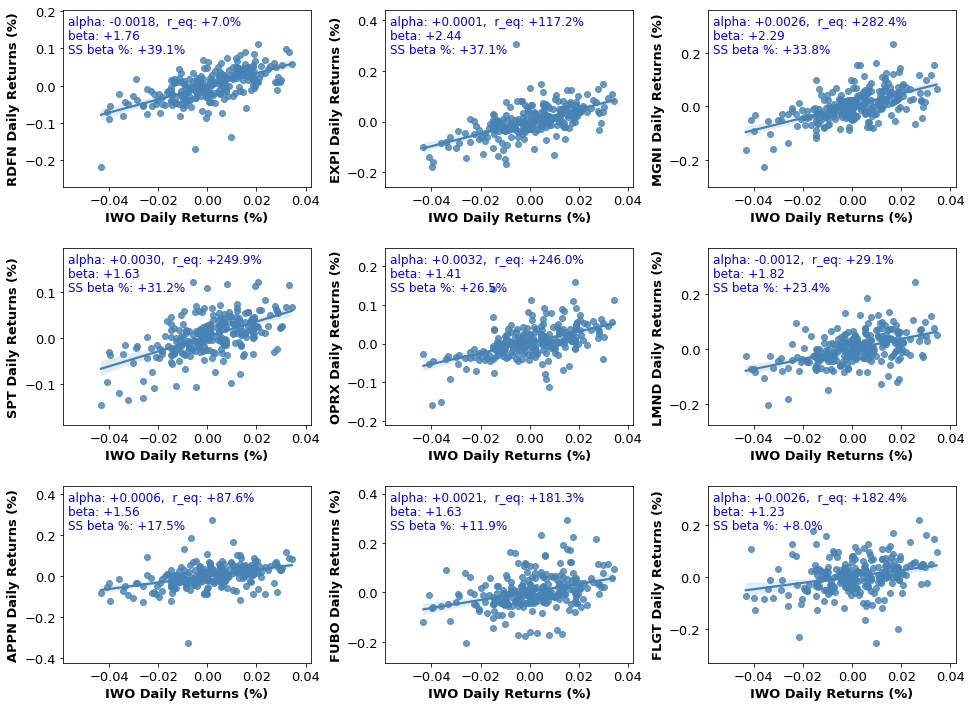

In [9]:
#loop single stock, plot stock vs ETF daily return
is_singstk04 = df_price_eod_de_smlst.loc[:,'sectype'] == 'SS'
ticklst04 = list(df_abeps_res.sort_values(by='SSpct_beta_rk').loc[:,'ticker_y'])
etftick04 = 'IWO'
is_etfbnch04 = df_price_eod_de_smlst.loc[:,'ticker'] == etftick04
df_etfbnch04 = df_price_eod_de_smlst.loc[is_etfbnch04,['date','ticker','clsadj_lndif01']]

#figure with subplots
n_tick04 = len(ticklst04)

fig04, axes04 = plt.subplots(nrows=3,ncols=3,figsize=(16,12))
fig04.subplots_adjust(wspace=0.3, hspace=0.35)
axes04_flt = axes04.flatten()

ct04 = -1
#for tickn04 in ticklst04:
for idx04,rcd04 in df_abeps_res.sort_values(by='SSpct_beta_rk').iterrows():
    #ticker metrics
    tickn04 = rcd04[0]
    alphan04 = rcd04[5]
    r_eqn04 = rcd04[3]
    betan04 = rcd04[7]
    SSbetapctn04 = rcd04[15]
    
    #get single stock data
    is_tickn04 = df_price_eod_de_smlst.loc[:,'ticker'] == tickn04
    df_singstk04 = df_price_eod_de_smlst.loc[is_tickn04,['date','ticker','clsadj_lndif01']]
    #join datasets on date, dropna; get y, X
    df_yxdata04 = df_singstk04.merge(right=df_etfbnch04,how='inner',on='date',suffixes=['_y','_x']).dropna().reset_index(drop=True)
    
    #plot
    ct04 = ct04 + 1
    axes04_n = axes04_flt[ct04]
    sns.regplot(ax=axes04_n,x=df_yxdata04['clsadj_lndif01_x'],y=df_yxdata04['clsadj_lndif01_y'],color='steelblue')
    axes04_n.set_xlabel(etftick04 + ' Daily Returns (%)', fontsize=13.0, fontweight='bold')
    axes04_n.tick_params(axis='x', labelsize=13)
    axes04_n.set_ylabel(tickn04 + ' Daily Returns (%)', fontsize=13.0, fontweight='bold')
    axes04_n.tick_params(axis='y', labelsize=13) 
    
    #annotate scatter plot
    x_lim_rng04 = axes04_n.get_xlim()[1] - axes04_n.get_xlim()[0]
    y_lim_rng04 = axes04_n.get_ylim()[1] - axes04_n.get_ylim()[0]
    axes04_n.set_ylim(axes04_n.get_ylim()[0] - 0.10*y_lim_rng04,axes04_n.get_ylim()[1] + 0.20*y_lim_rng04)
    axes04_n.set_xlim(axes04_n.get_xlim()[0] - 0.20*x_lim_rng04,axes04_n.get_xlim()[1] + 0.10*x_lim_rng04)
    
    x_lim_rng04 = axes04_n.get_xlim()[1] - axes04_n.get_xlim()[0]
    y_lim_rng04 = axes04_n.get_ylim()[1] - axes04_n.get_ylim()[0]

    x_text04 = axes04_n.get_xlim()[0] + 0.02*x_lim_rng04
    y_alpha04 = axes04_n.get_ylim()[1] - 0.08*y_lim_rng04
    y_beta04 = axes04_n.get_ylim()[1] - 0.16*y_lim_rng04
    y_SSbetapct04 = axes04_n.get_ylim()[1] - 0.24*y_lim_rng04
    
    alpha_text04 = 'alpha: ' + '{:+.4f}'.format(alphan04) + ',  r_eq: ' + '{:+.1%}'.format(r_eqn04)
    beta_text04 = 'beta: ' + '{:+.2f}'.format(betan04)
    SSbetapct_text04 = 'SS beta %: ' + '{:+.1%}'.format(SSbetapctn04)

    axes04_n.text(x_text04, y_alpha04, alpha_text04, fontsize=12.0, color='blue')
    axes04_n.text(x_text04, y_beta04, beta_text04, fontsize=12.0, color='blue')
    axes04_n.text(x_text04, y_SSbetapct04, SSbetapct_text04, fontsize=12.0, color='blue')


## 5 Final Conclusions
These results show how for some stocks a substantial amount (>30%) of the variation in stock returns may be explained by a correlation with a market benchmark. Further, the strength of the relationship between a stock and a benchmark varies considerably among stocks, from beta = 1.23 to beta = 2.44 in the examples considered here.  Yet, for other stocks the correlation with a benchmark is weak and other factors are driving variation in stock returns, including perhaps other benchmarks not considered here, which is an important possibility to recognize.  These results demonstrate an interesting approach for trying to understand the extent to which a stock's returns are driven by overall market trends versus factors specific to the stock, such as the company's economic performance.